In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [3]:
# Load the dataset
df = pd.read_csv('Interbank FX Rates Historical (2).csv')
df.head(100)
data = data.set_index()

,Selling,Mid Rate
0,0.8636,0.4318
1,0.8632,0.4316
2,0.8641,0.4321
3,0.8575,0.4288
4,0.8623,0.4312
...,...,...
95,0.9626,0.4813
96,0.9645,0.4823
97,0.9648,0.4824
98,0.9653,0.4827


In [4]:
# Remove any rows with missing values
df.dropna(inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

In [5]:
# Split the dataset into training, validation, and testing sets
train_df = df.iloc[:int(len(df)*0.6)]
val_df = df.iloc[int(len(df)*0.6):int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]

In [6]:
# Standardize the data

#buying_mean = train_df['Buying'].mean()
#buying_std = train_df['Buying'].std()
selling_mean = train_df['Selling'].mean()
selling_std = train_df['Selling'].std()
mid_rate_mean = train_df['Mid Rate'].mean()
mid_rate_std = train_df['Mid Rate'].std()


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)


In [8]:
# Define the neural network model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(16, activation='relu'),
    Dense(1)
])

In [9]:

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_df[[ 'Selling']].values, 
                    train_df['Mid Rate'].values, 
                    validation_data=(val_df[['Selling']].values, val_df['Mid Rate'].values), 
                    epochs=100, batch_size=32)

Epoch 1/100
61/61 [==============================] - 4s 8ms/step - loss: nan - val_loss: nan
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 8/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 9/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 10/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 11/100
61/61 [==============================] - 0s 3ms/step - l

In [10]:
history.history

{'loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'val_loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

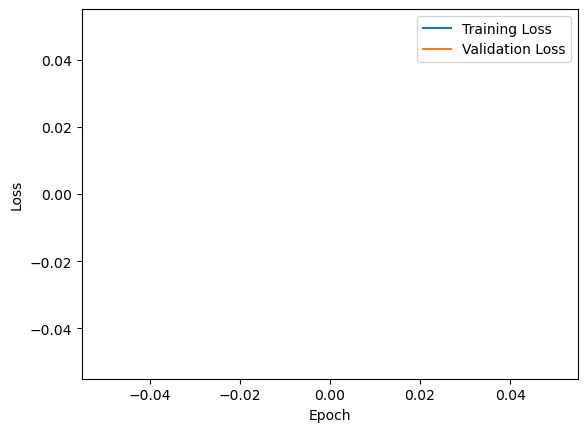

In [46]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:

# Make predictions on the testing data
predictions = model.predict(test_df[[ 'Selling']].values)

21/21 [==============================] - 0s 2ms/step


In [64]:
# Denormalize the predictions and actual values
predictions = predictions * mid_rate_std + mid_rate_mean
actual_values = test_df['Mid Rate'].values

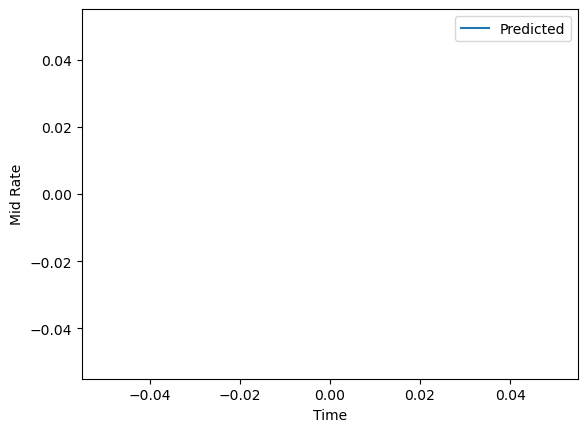

In [81]:
# Plot the predicted and actual values
plt.plot(predictions, label='Predicted')
#plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

In [1]:
# Plot the predicted and actual values
plt.plot(predictions, marker = 'o' ,label='Predicted')
plt.plot(actual_values,marker = '*', label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

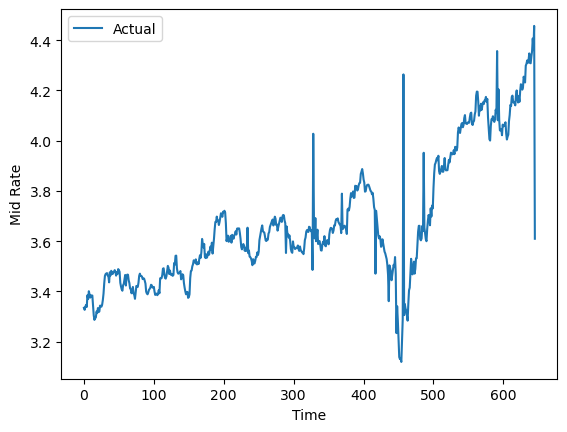

In [84]:
# Plot the predicted and actual values
#plt.plot(predictions, label='Predicted')
plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()